In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

%matplotlib inline

torch.manual_seed(12046)

In [3]:
# 准备数据
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
# 将数据划分成训练集、验证集、测试集
train_set, val_set = random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
len(train_set), len(val_set), len(test_set)

(50000, 10000, 10000)

In [8]:
x, y = dataset[21]
x.shape

torch.Size([1, 28, 28])

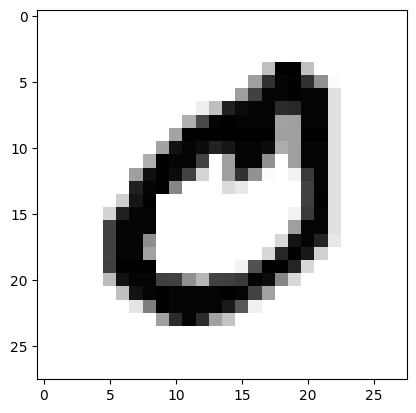

In [9]:
plt.imshow(x.squeeze(0).numpy(), cmap=plt.cm.binary)

In [4]:
# 构建数据读取器
train_loader = DataLoader(train_set, batch_size=500, shuffle=True)
val_loader = DataLoader(val_set, batch_size=500, shuffle=True)
test_loader = DataLoader(test_set, batch_size=500, shuffle=True)

In [5]:
# 获取一个批量的数据
x, y = next(iter(train_loader))
x.shape, y.shape, x.view(x.shape[0], -1).shape

(torch.Size([500, 1, 28, 28]), torch.Size([500]), torch.Size([500, 784]))

In [6]:
# 两种常见实现方式
## 自由度更大的实现方式
class MLP(nn.Module):

  def __init__(self):
    super().__init__()
    self.hidden1 = nn.Linear(784, 30)
    self.hidden2 = nn.Linear(30, 20)
    self.out = nn.Linear(20, 10)
  
  def forward(self, X):
    '''
    多层感知器的前向传播
    参数
    ____
    x: torch.FloatTensor, 形状为(B, 784)，其中B表示批量数据的大小
    '''
    x = F.sigmoid(self.hidden1(x))
    x = F.sigmoid(self.hidden2(x))
    x = self.out(x)
    return x
  
model = MLP()

## 更简洁的实现方式
model = nn.Sequential(
  nn.Linear(784, 30), nn.Sigmoid(),
  nn.Linear(30, 20), nn.Sigmoid(),
  nn.Linear(20, 10)
)

In [7]:
eval_iters = 10

def estimate_loss(model):
  re = {}
  # 将模型切换为评估模式
  model.eval()
  re['train'] = _loss(model, train_loader)
  re['val'] = _loss(model, val_loader)
  re['test'] = _loss(model, test_loader)
  # 将模型切换为训练模式
  model.train()
  return re

@torch.no_grad()
def _loss(model, dataloader):
  # 估计模型效果
  loss = []
  acc = []
  data_iter = iter(dataloader)
  for t in range(eval_iters):
    inputs, labels = next(data_iter)
    # inputs: (500, 1, 28, 28)
    # labels: (500)
    B, C, H, W = inputs.shape
    logits = model(inputs.view(B, -1))
    loss.append(F.cross_entropy(logits, labels))
    # preds = torch.argmax(F.softmax(logits, dim=-1), dim=-1)
    preds = torch.argmax(logits, dim=-1)
    acc.append((preds == labels).sum() / B)
  re = {
    'loss': torch.tensor(loss).mean().item(),
    'acc': torch.tensor(acc).mean().item()
  }
  return re

运行结果大概是

```
{'train': {'loss': 2.3977837562561035, 'acc': 0.10039999336004257},
 'val': {'loss': 2.40299916267395, 'acc': 0.1095999926328659},
 'test': {'loss': 2.3904480934143066, 'acc': 0.10520000755786896}}
```

这里符合预期，10个数，随机选择概率是10%

In [10]:
estimate_loss(model)

{'train': {'loss': 2.3977837562561035, 'acc': 0.10039999336004257},
 'val': {'loss': 2.40299916267395, 'acc': 0.1095999926328659},
 'test': {'loss': 2.3904480934143066, 'acc': 0.10520000755786896}}

In [15]:
def train_model(model, optimizer, epochs=10, penalty=False):
  lossi = []
  for e in range(epochs):
    for data in train_loader:
      inputs, labels = data
      B, C, H, W = inputs.shape
      logits = model(inputs.view(B, -1))
      loss = F.cross_entropy(logits, labels)
      lossi.append(loss.item())
      if penalty:
        w = torch.cat([p.view(-1) for p in model.parameters()])
        loss += 0.001 * w.abs().sum() + 0.002 * w.square().sum()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    stats = estimate_loss(model)
    train_loss = f'{stats["train"]["loss"]:.3f}'
    val_loss = f'{stats["val"]["loss"]:.3f}'
    test_loss = f'{stats["test"]["loss"]:.3f}'
    print(f'epoch {e} train {train_loss} val {val_loss} test {test_loss}')
  return lossi


In [16]:
loss = {}

In [17]:
model = nn.Sequential(
  nn.Linear(784, 30), nn.Sigmoid(),
  nn.Linear(30, 20), nn.Sigmoid(),
  nn.Linear(20, 10)
)

loss['mlp'] = train_model(model, optim.SGD(model.parameters(), lr=0.01))

epoch 0 train 2.314 val 2.311 test 2.316
epoch 1 train 2.305 val 2.302 test 2.306
epoch 2 train 2.303 val 2.301 test 2.301
epoch 3 train 2.299 val 2.301 test 2.300
epoch 4 train 2.299 val 2.299 test 2.300
epoch 5 train 2.298 val 2.300 test 2.299
epoch 6 train 2.299 val 2.300 test 2.299
epoch 7 train 2.298 val 2.300 test 2.298
epoch 8 train 2.297 val 2.299 test 2.298
epoch 9 train 2.298 val 2.298 test 2.297


### ReLU

In [18]:
model = nn.Sequential(
  nn.Linear(784, 30), nn.ReLU(),
  nn.Linear(30, 20), nn.ReLU(),
  nn.Linear(20, 10)
)

loss['mlp_relu'] = train_model(model, optim.SGD(model.parameters(), lr=0.01))

epoch 0 train 2.287 val 2.292 test 2.288
epoch 1 train 2.258 val 2.265 test 2.256
epoch 2 train 2.218 val 2.224 test 2.217
epoch 3 train 2.158 val 2.166 test 2.158
epoch 4 train 2.061 val 2.061 test 2.059
epoch 5 train 1.909 val 1.904 test 1.899
epoch 6 train 1.711 val 1.714 test 1.692
epoch 7 train 1.462 val 1.458 test 1.452
epoch 8 train 1.196 val 1.200 test 1.162
epoch 9 train 0.980 val 0.978 test 0.952


### 归一化

In [19]:
model = nn.Sequential(
    nn.Linear(784, 30, bias=False), nn.LayerNorm(30), nn.ReLU(),
    nn.Linear( 30, 20, bias=False), nn.LayerNorm(20), nn.ReLU(),
    nn.Linear( 20, 10)
)

loss['mlp_relu_layer'] = train_model(model, optim.SGD(model.parameters(), lr=0.01))

epoch 0 train 1.448 val 1.444 test 1.434
epoch 1 train 1.090 val 1.086 test 1.087
epoch 2 train 0.825 val 0.817 test 0.816
epoch 3 train 0.626 val 0.643 test 0.637
epoch 4 train 0.528 val 0.513 test 0.520
epoch 5 train 0.423 val 0.429 test 0.425
epoch 6 train 0.364 val 0.386 test 0.376
epoch 7 train 0.332 val 0.340 test 0.339
epoch 8 train 0.318 val 0.313 test 0.303
epoch 9 train 0.286 val 0.285 test 0.283


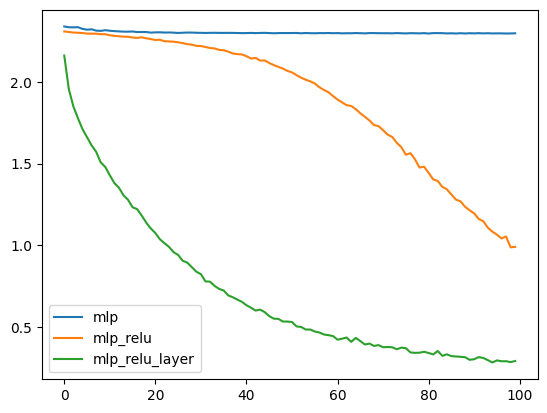

In [20]:
for i in ['mlp', 'mlp_relu', 'mlp_relu_layer']:
  plt.plot(torch.tensor(loss[i]).view(-1, 10).mean(dim=-1), label=i)
plt.legend()
plt.show()

In [21]:
model = nn.Sequential(
    nn.Linear(784, 30, bias=False), nn.LayerNorm(30), nn.ReLU(),
    nn.Linear( 30, 20, bias=False), nn.LayerNorm(20), nn.ReLU(),
    nn.Linear( 20, 10)
)

# 增加epochs，模型过拟合
loss['mlp_relu_layer'] = train_model(model, optim.Adam(model.parameters(), lr=0.01), epochs=20)

epoch 0 train 0.191 val 0.207 test 0.203
epoch 1 train 0.132 val 0.160 test 0.161
epoch 2 train 0.099 val 0.131 test 0.130
epoch 3 train 0.095 val 0.140 test 0.135
epoch 4 train 0.086 val 0.140 test 0.120
epoch 5 train 0.067 val 0.135 test 0.127
epoch 6 train 0.069 val 0.146 test 0.116
epoch 7 train 0.054 val 0.111 test 0.114
epoch 8 train 0.045 val 0.134 test 0.119
epoch 9 train 0.056 val 0.134 test 0.114
epoch 10 train 0.063 val 0.143 test 0.157
epoch 11 train 0.043 val 0.139 test 0.134
epoch 12 train 0.058 val 0.147 test 0.142
epoch 13 train 0.043 val 0.140 test 0.138
epoch 14 train 0.060 val 0.159 test 0.167
epoch 15 train 0.040 val 0.149 test 0.148
epoch 16 train 0.033 val 0.127 test 0.116
epoch 17 train 0.031 val 0.146 test 0.143
epoch 18 train 0.025 val 0.136 test 0.132
epoch 19 train 0.022 val 0.139 test 0.145


### Dropout

In [22]:
m = nn.Dropout(0.5)
x = torch.randn(5, requires_grad=True)

In [23]:
x

tensor([-1.0541, -0.5766, -1.7516, -0.4524, -0.6323], requires_grad=True)

In [24]:
m.train()
l = m(x)
l.sum().backward()
l, x.grad

(tensor([-0.0000, -1.1532, -0.0000, -0.9048, -0.0000], grad_fn=<MulBackward0>),
 tensor([0., 2., 0., 2., 0.]))

In [25]:
m.eval()
m(x)

tensor([-1.0541, -0.5766, -1.7516, -0.4524, -0.6323], requires_grad=True)

In [26]:
m.training

False

In [27]:
model = nn.Sequential(
    nn.Linear(784, 30, bias=False), nn.LayerNorm(30), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear( 30, 20, bias=False), nn.LayerNorm(20), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear( 20, 10)
)

loss['mlp_relu_layer_dropout'] = train_model(model, optim.Adam(model.parameters(), lr=0.01), epochs=20)

epoch 0 train 0.255 val 0.270 test 0.283
epoch 1 train 0.214 val 0.230 test 0.217
epoch 2 train 0.164 val 0.195 test 0.196
epoch 3 train 0.151 val 0.197 test 0.190
epoch 4 train 0.133 val 0.176 test 0.171
epoch 5 train 0.146 val 0.173 test 0.154
epoch 6 train 0.124 val 0.180 test 0.188
epoch 7 train 0.123 val 0.149 test 0.163
epoch 8 train 0.142 val 0.156 test 0.166
epoch 9 train 0.135 val 0.162 test 0.147
epoch 10 train 0.112 val 0.158 test 0.131
epoch 11 train 0.114 val 0.150 test 0.152
epoch 12 train 0.111 val 0.132 test 0.162
epoch 13 train 0.114 val 0.145 test 0.134
epoch 14 train 0.107 val 0.145 test 0.145
epoch 15 train 0.101 val 0.146 test 0.152
epoch 16 train 0.099 val 0.145 test 0.143
epoch 17 train 0.090 val 0.160 test 0.164
epoch 18 train 0.086 val 0.141 test 0.145
epoch 19 train 0.098 val 0.156 test 0.141


### 惩罚项

In [28]:
model = nn.Sequential(
    nn.Linear(784, 30, bias=False), nn.LayerNorm(30), nn.ReLU(),
    nn.Linear( 30, 20, bias=False), nn.LayerNorm(20), nn.ReLU(),
    nn.Linear( 20, 10)
)

_ = train_model(model, optim.Adam(model.parameters(), lr=0.01), epochs=20, penalty=True)

epoch 0 train 0.279 val 0.294 test 0.289
epoch 1 train 0.231 val 0.245 test 0.233
epoch 2 train 0.220 val 0.245 test 0.226
epoch 3 train 0.269 val 0.277 test 0.261
epoch 4 train 0.240 val 0.233 test 0.230
epoch 5 train 0.241 val 0.223 test 0.224
epoch 6 train 0.222 val 0.237 test 0.219
epoch 7 train 0.221 val 0.228 test 0.224
epoch 8 train 0.224 val 0.277 test 0.249
epoch 9 train 0.204 val 0.223 test 0.210
epoch 10 train 0.242 val 0.249 test 0.235
epoch 11 train 0.233 val 0.245 test 0.232
epoch 12 train 0.208 val 0.223 test 0.209
epoch 13 train 0.211 val 0.228 test 0.209
epoch 14 train 0.207 val 0.226 test 0.214
epoch 15 train 0.221 val 0.222 test 0.216
epoch 16 train 0.211 val 0.234 test 0.220
epoch 17 train 0.207 val 0.216 test 0.220
epoch 18 train 0.257 val 0.269 test 0.253
epoch 19 train 0.239 val 0.243 test 0.224


In [29]:
estimate_loss(model)

{'train': {'loss': 0.21983841061592102, 'acc': 0.9375999569892883},
 'val': {'loss': 0.25200214982032776, 'acc': 0.9314000010490417},
 'test': {'loss': 0.22753456234931946, 'acc': 0.9362000226974487}}